In [1]:
import nldi_xstool
%matplotlib inline
from nldi_xstool.XSGen import XSGen
from nldi_xstool.ancillary import query_dems_bbox
import py3dep
from pynhd import NLDI, NHDPlusHR, WaterData
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import dataretrieval.nwis as nwis

import ee # Google Earth Engine

/home/sarah/anaconda3/envs/py39/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


## Use NWIS data to get days of high discharge from gage locations

getSiteData uses NWIS to get data about a registered data collection location with a stream gage.

In [2]:
def getSiteData(site_number, start_date, end_date):
    measurements = nwis.get_record(sites=site_number, service='measurements')
    site_info = nwis.get_record(sites=site_number, service='site')
    instantaneous_discharge = nwis.get_record(sites=site_number, service='iv', start=start_date, end=end_date)
    daily_discharge = nwis.get_record(sites=site_number, service='dv', start=start_date, end=end_date)
    peak_discharge = nwis.get_record(sites=site_number, service='peaks', start=start_date, end=end_date)
    return [measurements, site_info, instantaneous_discharge, daily_discharge, peak_discharge]

getDailyDischargeFromSite gets just the daily discharge data based on the selected site.

In [3]:
def getDailyDischargeFromSite(site_number, start_date, end_date):
    return nwis.get_record(sites=site_number, service='dv', start=start_date, end=end_date)

getDailyDischargeValuesAboveThreshold returns the dataframe rows form the NWIS daily discharge dataset that are above a given discharge threshold. This function optionally displays a graph of the results.

In [4]:
def getDailyDischargeValuesAboveThreshold(daily_discharge, discharge_cfs_threshold, title, plot_dates): 
    threshold_met = daily_discharge.loc[daily_discharge['00060_Mean'] >= discharge_cfs_threshold]
    # optional plotting of dates
    if(plot_dates):
        fig, ax = plt.subplots()
        ax.scatter(x= threshold_met.index, y=threshold_met['00060_Mean'])
        title_text =  title + "Daily Mean Discharge Values Above "+str(discharge_cfs_threshold)+" cfs"
        ax.set_title(title_text)
        ax.set_xlabel("Dates")
        ax.set_ylabel("Discharge (cfs)")
        plt.xticks(rotation = 45)
        plt.show()
        
    return threshold_met

In [5]:
def getDailyDischargeValuesBetweenThresholds(daily_discharge, discharge_cfs_threshold_lower, discharge_cfs_threshold_upper, title, plot_dates): 
    threshold_met = daily_discharge.loc[daily_discharge['00060_Mean'] >= discharge_cfs_threshold_lower].loc[daily_discharge['00060_Mean'] <= discharge_cfs_threshold_upper]
    
    # optional plotting of dates
    if(plot_dates):
        fig, ax = plt.subplots()
        ax.scatter(x= threshold_met.index, y=threshold_met['00060_Mean'])
        title_text = title + "Daily Mean Discharge Values Above " +str(discharge_cfs_threshold_lower)+ " and " +str(discharge_cfs_threshold_upper)+ " cfs"
        ax.set_title(title_text)
        ax.set_xlabel("Dates")
        ax.set_ylabel("Discharge (cfs)")
        plt.xticks(rotation = 45)
        plt.show()
        
    return threshold_met

reformatDatesForGoogleEarthEngine formats the dates from the NWIS datafram so that they can be used in Google Earth Engine

In [6]:
def reformatDatesForGoogleEarthEngine(discharge_threshold_met_dataframe):
    date = [ time.strftime("%Y-%m-%d") for time in discharge_threshold_met_dataframe.index.tolist()]
    return date

getDatesAboveDischargeThreshold combines the above functions into one call

In [7]:
def getDatesAboveDischargeThreshold(site_number, start_date, end_date, discharge_cfs_threshold, title = "", plot_dates = True):
    # get data for site by site number
    daily_discharge = getDailyDischargeFromSite(site_number, start_date, end_date)
    
    # get dataframe values for given discharge threshold
    discharge_threshold_met_dataframe = getDailyDischargeValuesAboveThreshold(daily_discharge, discharge_cfs_threshold, title, plot_dates)
    
    # return the dates in Google Earth Engine format
    return reformatDatesForGoogleEarthEngine(discharge_threshold_met_dataframe), discharge_threshold_met_dataframe

In [8]:
def getDatesBetweenDischargeThreshold(site_number, start_date, end_date, discharge_cfs_threshold_lower, discharge_cfs_threshold_upper, title = "", plot_dates = True):
    # get data for site by site number
    daily_discharge = getDailyDischargeFromSite(site_number, start_date, end_date)
    
    # get dataframe values for given discharge threshold
    discharge_threshold_met_dataframe = getDailyDischargeValuesBetweenThresholds(daily_discharge, discharge_cfs_threshold_lower, discharge_cfs_threshold_upper, title, plot_dates)
    
    # return the dates in Google Earth Engine format
    return reformatDatesForGoogleEarthEngine(discharge_threshold_met_dataframe), discharge_threshold_met_dataframe

getDischargeFromDate takes a site number and a date and returns the mean discharge for that day. This will later be used for graphing area vs discharge.

In [9]:
def getDischargeFromDate(site_number, date):
    dateRange = dateToString(date)
    return getDailyDischargeFromSite(site_number, dateRange[0], dateRange[1]).iloc[0]["00060_Mean"]

Case 1: Matilija

In [ ]:
matilija_site_number='11114495'
start_date = '2014-12-31'
end_date = '2020-01-01'
matilija_discharge_cfs_threshold = 100

matilija_dates_above_threshold, matilija_dates_df = getDatesAboveDischargeThreshold(matilija_site_number, start_date, end_date, 
                                                                 matilija_discharge_cfs_threshold)

In [ ]:
print(matilija_dates_above_threshold)

In [ ]:
matilija_dates_df

Case 2: Willamette River at Harrisburg, OR

In [ ]:
willamette_site_number='14166000'
start_date = '2001-10-01'
end_date = '2021-09-30'
willamette_discharge_cfs_threshold = 30000

willamette_dates_above_threshold, willamette_dates_df = getDatesAboveDischargeThreshold(willamette_site_number, start_date, end_date, 
                                                                 willamette_discharge_cfs_threshold)

In [ ]:
print(willamette_dates_above_threshold)

Case 3: Mississippi River at Vicksburg, MS

In [ ]:
mississippi_site_number='07289000'
start_date = '2001-10-01'
end_date = '2021-09-30'
mississippi_discharge_cfs_threshold = 1200000

mississippi_dates_above_threshold, mississippi_dates_df = getDatesAboveDischargeThreshold(mississippi_site_number, start_date, end_date, 
                                                                 mississippi_discharge_cfs_threshold)

In [ ]:
print(mississippi_dates_above_threshold)

Now, we want to take to above dates and run them in Google Earth Engine. The below code gets a verification token to authenticate the user.

## Mapping dates with Google Earth Engine

In [10]:
ee.Authenticate()

Enter verification code: 4/1AX4XfWhwG0-j5xl9XyRiUzUwvO48aQxsxIPT4uriRvhSlVObLLW3KqW2yI0

Successfully saved authorization token.


In [11]:
ee.Initialize()

Getting satellite data for imaging.

In [12]:

sentinel2 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED");
landsat8 = ee.ImageCollection("LANDSAT/LC08/C02/T1_TOA")


Helper functions to use ee

In [13]:
# interactive map for images
import geemap

mapColor = ['45a248', '1c3da2']

In [14]:
from datetime import datetime
from datetime import timedelta

def dateToString(date):
    start_date = datetime.strptime(date, "%Y-%m-%d")
    end_date = start_date + timedelta(days=1)
    return [start_date.strftime("%Y-%m-%d"), end_date.strftime("%Y-%m-%d")]

In [15]:
# get the image collection of all images from the dates passes
def getListOfImages(datesList, location, satellite, cloud_percentage = 10):
    images = []
  
    for date in datesList:
        # get the day number in the year of the date so we can look
        # it up 
        searchDates = dateToString(date)
    
        # get image form given date with least cloud cover
        
        satelliteImageForDate = ee.ImageCollection(satellite) \
        .filterBounds(location) \
        .filterDate(searchDates[0], searchDates[1]) \
        .sort('CLOUD_COVER') \
        .first()

        # when the image is not null we want to add it to our list of 
        # images
        if (satelliteImageForDate):
            images.append(satelliteImageForDate)


    # turn images found into a collection so we can map them
    collectionFromImages = ee.ImageCollection.fromImages(images)

    #filteredCollection = withCloudiness.filter(ee.Filter.lt('cloud', cloud_percentage));
    #print(filteredCollection);

    
    # filter image on clouds on pick geometry location
    filtered = collectionFromImages.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', cloud_percentage)) \
        .filter(ee.Filter.bounds(location))
    return filtered
    


In [16]:
def getNDWIFromImage(image):
    mndwi = image.normalizedDifference(['B3', 'B5'])
    return mndwi.gt(0)

In [17]:
def getMNDWIFromImage(image):
    mndwi = image.normalizedDifference(['B3', 'B11'])
    return mndwi.gt(0)

In [18]:
# map the image collection 
def mapImageCollection(imageCollection, ndwiType = "NDWI"):
    Map = geemap.Map()
    image = imageCollection.first()

    vis_param = {'min': 0, 
                 'max': 2000, 
                 'bands': ['B5', 'B4', 'B3'], 
                 'gamma': 1.5}
    Map.addLayer(image, vis_param, "First mage")
    Map.centerObject(image, 8)    
   
    mosaic = imageCollection.mosaic()

    medianComposite = imageCollection.median()
    
    rgbVis = {
        'min': 0.0,
        'max': 3000,
        'bands': ['B4', 'B3', 'B2'],
    }

    Map.addLayer(imageCollection, rgbVis, 'Filtered Collection');
    Map.addLayer(mosaic, rgbVis, 'Mosaic');
    Map.addLayer(medianComposite, rgbVis, 'Median Composite')

    if ndwiType == "NDWI":
        water = getNDWIFromImage(image)
    elif ndwiType == "MNDWI":
        water = getMNDWIFromImage(image)
    Map.addLayer(water, {'min': 0.5, 'max':1, 'palette': mapColor}, "ndwiMosaic")
    return Map

Make a map from an image collection

In [19]:
# map a single ndwi image from a given date
def mapImageFromDate(date, location, satellite, ndwiType = "NDWI"):
    Map = geemap.Map()
    dateRange = dateToString(date)
    image = satellite \
      .filterBounds(location) \
      .filterDate(dateRange[0], dateRange[1]) \
      .sort('CLOUD_COVER') \
      .first()
    if ndwiType == "NDWI":
        water = getNDWIFromImage(image)
    elif ndwiType == "MNDWI":
        water = getMNDWIFromImage(image)

    Map.addLayer(water, {'min': 0.5, 'max':1, 'palette': mapColor})    
    
    return Map

Map an image from a date when we already have the image collection

In [20]:
# map a single ndwi image from a given date
def mapImageFromDateAndImageCollection(date, location, satellite, imageCollection, ndwiType = "NDWI"):
    # get the image for the date
    image = getImageFromDate(date, imageCollection)
    Map = geemap.Map()
    
    # make mndwi for looking at water vs non-water
    if ndwiType == "NDWI":
        water = getNDWIFromImage(image)
    elif ndwiType == "MNDWI":
        water = getMNDWIFromImage(image)
    
    # plot water as blue and land as green
    Map.addLayer(water, {'min': 0.5, 'max':1, 'palette': mapColor})    
    
    return Map

Get the image from the image collection for a given date

In [21]:
def getImageFromDate(date, imageCollection):
    searchDates = dateToString(date)
    return imageCollection.filterDate(searchDates[0], searchDates[1]).first()

getAreaFromDate takes a date and gets the area within the geometry (location) that is water

In [22]:
def getAreaFromDate(date, location, satellite, ndwiType = "NDWI"):
    Map = geemap.Map()
    dateRange = dateToString(date)
    image = satellite \
      .filterBounds(location) \
      .filterDate(dateRange[0], dateRange[1]) \
      .sort('CLOUD_COVER') \
      .first()
    
    if ndwiType == "NDWI":
        water = getNDWIFromImage(image)
    elif ndwiType == "MNDWI":
        water = getMNDWIFromImage(image)

    Map.addLayer(water, {'min': 0.5, 'max':1, 'palette': mapColor})
    areaImage = water.multiply(ee.Image.pixelArea())
    area = areaImage.reduceRegion(reducer = ee.Reducer.sum(), 
      geometry = location, 
      scale = 20, 
      maxPixels= 1e10 
      )
    urbanAreaSqKm = ee.Number(
      area.get('nd')).divide(1e6)
    return urbanAreaSqKm.getInfo()

In [23]:
def getAreaFromImage(image, location, satellite, ndwiType = "NDWI"):
    Map = geemap.Map()
    if ndwiType == "NDWI":
        water = getNDWIFromImage(image)
    elif ndwiType == "MNDWI":
        water = getMNDWIFromImage(image)
    Map.addLayer(water, {'min': 0.5, 'max':1, 'palette': mapColor})
    areaImage = water.multiply(ee.Image.pixelArea())
    area = areaImage.reduceRegion(reducer = ee.Reducer.sum(), 
      geometry = location, 
      scale = 20, 
      maxPixels= 1e10 
      )
    urbanAreaSqKm = ee.Number(
      area.get('nd')).divide(1e6)
    return urbanAreaSqKm.getInfo()

In [24]:
# get all dates that returned an image in the image collection
def getDatesFromImageCollection(imageCollection, time = False):
    dates = []
    for feature in imageCollection.getInfo()['features']:
        ms = feature['properties']['system:time_start']
        if time:
            dateOfImage = datetime.fromtimestamp(ms/1000.0).strftime("%Y-%m-%d, %H:%M:%S")
        else: 
            dateOfImage = datetime.fromtimestamp(ms/1000.0).strftime("%Y-%m-%d")
        dates.append(dateOfImage)
    return dates

In [ ]:
matilijaGageLocation = ee.Geometry.Point(-119.30795921344384, 34.48573359710931)

matilijaGeometry = ee.Geometry.Polygon(
        [[[-119.31594286538936, 34.49174896054574],
          [-119.31594286538936, 34.48219820073181],
          [-119.30285368539668, 34.48219820073181],
          [-119.30285368539668, 34.49174896054574]]], None, False);
matilija_collection = getListOfImages(matilija_dates_above_threshold, matilijaGeometry, sentinel2)
Map = mapImageCollection(matilija_collection)
lat = 34.48573359710931
lon = -119.30795921344384
zoom = 15
Map.setCenter(lon, lat, zoom)
Map

In [ ]:
matilija_date_list = getDatesFromImageCollection(matilija_collection)

In [ ]:
print(matilija_date_list)

## Getting area of water shown on map

In [ ]:
Map = mapImageFromDateAndImageCollection('2019-02-08', matilijaGeometry, sentinel2, matilija_collection)
lat = 34.48573359710931
lon = -119.30795921344384
zoom = 15
Map.setCenter(lon, lat, zoom)
Map

## Plotting dischange vs water area 

In [ ]:
area = []
discharge = []
for date in matilija_date_list:
    area.append(getAreaFromDate(date, matilijaGeometry, sentinel2))
    discharge.append(getDischargeFromDate(matilija_site_number, date))

In [ ]:
print(area)
print(discharge)

In [ ]:
fig, ax = plt.subplots()
ax.scatter(discharge, area)
ax.set_title("Area of matilija vs discharge")
ax.set_xlabel("discharge")
ax.set_ylabel("area (km^2)")
plt.show()

###  Mississippi River

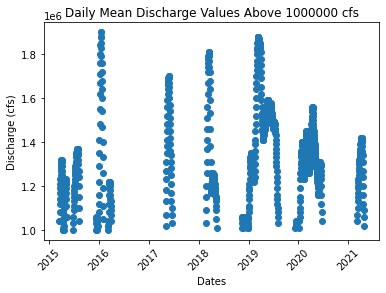

In [30]:
mississippi_site_number='07289000'
start_date = '2014-10-01'
end_date = '2021-09-30'
mississippi_discharge_cfs_threshold = 1000000
mississippi_geometry = ee.Geometry.Polygon(
        [[[-90.9177845688234, 32.335557854068995],
          [-90.91349303439956, 32.33432498989724],
          [-90.90920149997574, 32.33185921117534],
          [-90.90705573276382, 32.32808789026796],
          [-90.90619742587906, 32.325984585367834],
          [-90.90636908725601, 32.3243164122555],
          [-90.90774237827164, 32.32134263613644],
          [-90.90997397617203, 32.318441297029096],
          [-90.91143309787613, 32.315539864975015],
          [-90.9140938492189, 32.313146113562084],
          [-90.91615378574234, 32.31075229889282],
          [-90.90705573276382, 32.306544834979036],
          [-90.90387999729019, 32.30843096365433],
          [-90.90049373616061, 32.31354165282473],
          [-90.8994637678989, 32.31782132695719],
          [-90.89809047688327, 32.32072268592575],
          [-90.89731800068698, 32.322826113055285],
          [-90.89680301655612, 32.324784432324336],
          [-90.89457141865573, 32.32841083764998],
          [-90.89551555622897, 32.330151460612875],
          [-90.8954297255405, 32.33312494741842],
          [-90.89594470967135, 32.33602581602416],
          [-90.90263950337253, 32.34066701240601],
          [-90.91087924946628, 32.345452996869604]]]);

mississippi_dates_above_threshold, mississippi_dates_df = getDatesAboveDischargeThreshold(mississippi_site_number, start_date, end_date, 
                                                                 mississippi_discharge_cfs_threshold)

In [31]:
mississippi_image_collection = getListOfImages(mississippi_dates_above_threshold, mississippi_geometry, sentinel2, 2)
mississippi_map = mapImageCollection(mississippi_image_collection, "MNDWI")

# lat and lon for centering the map
mississippi_lat = 32.33
mississippi_lon = -90.91
zoom = 15
mississippi_map.setCenter(mississippi_lon, mississippi_lat, zoom)
mississippi_map

Map(center=[32.33, -90.91], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(childr…

In [32]:
mississippi_date_list = getDatesFromImageCollection(mississippi_image_collection)

In [33]:
print(mississippi_date_list)

['2019-01-06', '2019-01-21', '2019-03-22', '2019-04-21', '2019-04-26', '2019-05-16', '2019-05-26', '2019-07-25', '2020-03-26', '2020-04-30', '2020-05-10', '2021-03-21', '2021-03-26', '2021-04-20']


In [34]:
area = []
discharge = []
for date in mississippi_date_list:
    area.append(getAreaFromDate(date, mississippi_geometry, sentinel2, "MNDWI"))
    discharge.append(getDischargeFromDate(mississippi_site_number, date))

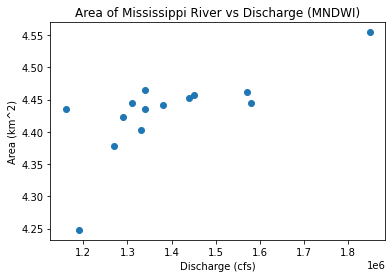

In [35]:
fig, ax = plt.subplots()
ax.scatter(discharge, area)
ax.set_title("Area of Mississippi River vs Discharge (MNDWI)")
ax.set_xlabel("Discharge (cfs)")
ax.set_ylabel("Area (km^2)")
plt.show()

## Willamette

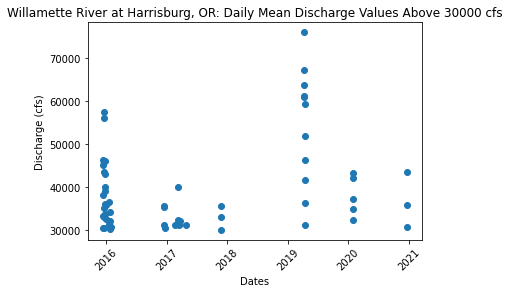

In [25]:
willamette_site_number='14166000'
start_date = '2015-10-01'
end_date = '2021-09-30'
willamette_discharge_cfs_threshold = 30000
willamette_geometry = ee.Geometry.Polygon(
        [[[-123.17735227170873, 44.27870641979654],
          [-123.17670854154515, 44.27683214434244],
          [-123.17606481138158, 44.27418962165109],
          [-123.17559274259496, 44.27004123588735],
          [-123.17585023466039, 44.26739840782829],
          [-123.17353280607152, 44.26638426783975],
          [-123.17353280607152, 44.2703178040482],
          [-123.17404779020238, 44.2746812627772],
          [-123.17400487485814, 44.27566453269001],
          [-123.17516358915258, 44.27855279291034],
          [-123.175421081218, 44.279136572940985]]]);

title = "Willamette River at Harrisburg, OR: "

willamette_dates_above_threshold, willamette_dates_df = getDatesAboveDischargeThreshold(willamette_site_number, start_date, end_date, 
                                                                 willamette_discharge_cfs_threshold, title)

In [26]:
willamette_image_collection = getListOfImages(willamette_dates_above_threshold, willamette_geometry, sentinel2, 50)
willamette_date_list = getDatesFromImageCollection(willamette_image_collection)
willamette_map = mapImageCollection(willamette_image_collection)
# lat and lon for centering the map
willamette_lat = 44.2787
willamette_lon = -123.177
zoom = 15
willamette_map.setCenter(willamette_lon, willamette_lat, zoom)
willamette_map

Map(center=[44.2787, -123.177], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(ch…

In [27]:
willamette_date_list = getDatesFromImageCollection(willamette_image_collection)
print(willamette_date_list)

['2019-04-18', '2020-01-28', '2020-12-23']


In [28]:
areas = []
discharges = []
for date in willamette_date_list:
    area = getAreaFromDate(date, willamette_geometry, sentinel2)
    discharge = getDischargeFromDate(willamette_site_number, date)
    areas.append(area)
    discharges.append(discharge)


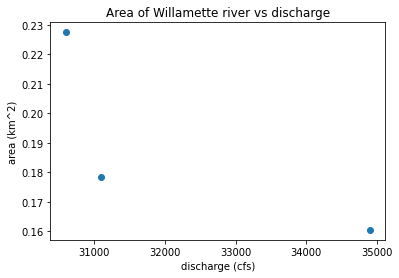

In [29]:
fig, ax = plt.subplots()
ax.scatter(discharges, areas)
ax.set_title("Area of Willamette river vs discharge")
ax.set_xlabel("discharge (cfs)")
ax.set_ylabel("area (km^2)")
plt.show()

In [ ]:
Map = mapImageFromDate('2019-04-18', willamette_geometry, sentinel2)
zoom = 15
Map.setCenter(willamette_lon, willamette_lat, zoom)
Map

In [ ]:
Map = mapImageFromDate('2020-01-28', willamette_geometry, sentinel2)
zoom = 15
Map.setCenter(willamette_lon, willamette_lat, zoom)
Map

In [ ]:
Map = mapImageFromDate('2020-12-23', willamette_geometry, sentinel2)
zoom = 15
Map.setCenter(willamette_lon, willamette_lat, zoom)
Map

In [ ]:
willamette_site_number='14166000'
start_date = '2015-10-01'
end_date = '2021-09-30'
willamette_discharge_cfs_threshold_lower = 10000
willamette_discharge_cfs_threshold_upper = 30000
title = "Willamette River at Harrisburg, OR: "

willamette_geometry = ee.Geometry.Polygon(
        [[[-123.17735227170873, 44.27870641979654],
          [-123.17670854154515, 44.27683214434244],
          [-123.17606481138158, 44.27418962165109],
          [-123.17559274259496, 44.27004123588735],
          [-123.17585023466039, 44.26739840782829],
          [-123.17353280607152, 44.26638426783975],
          [-123.17353280607152, 44.2703178040482],
          [-123.17404779020238, 44.2746812627772],
          [-123.17400487485814, 44.27566453269001],
          [-123.17516358915258, 44.27855279291034],
          [-123.175421081218, 44.279136572940985]]]);

willamette_dates_above_threshold, willamette_dates_df = getDatesBetweenDischargeThreshold(willamette_site_number, start_date, end_date, 
                                                                 willamette_discharge_cfs_threshold_lower, willamette_discharge_cfs_threshold_upper,title)

In [ ]:
willamette_image_collection = getListOfImages(willamette_dates_above_threshold, willamette_geometry, sentinel2, 10)
willamette_date_list = getDatesFromImageCollection(willamette_image_collection)
willamette_map = mapImageCollection(willamette_image_collection, "MNDWI")
# lat and lon for centering the map
willamette_lat = 44.2787
willamette_lon = -123.177
zoom = 15
willamette_map.setCenter(willamette_lon, willamette_lat, zoom)
willamette_map

In [ ]:
willamette_map = mapImageCollection(willamette_image_collection, "NDWI")
# lat and lon for centering the map
willamette_lat = 44.2787
willamette_lon = -123.177
zoom = 15
willamette_map.setCenter(willamette_lon, willamette_lat, zoom)
willamette_map

In [ ]:
willamette_date_list = getDatesFromImageCollection(willamette_image_collection)
print(willamette_date_list)
#print(getDatesFromImageCollection(willamette_image_collection, True))


Fixing timezone issue with sentinal and NLDI

In [ ]:
from pytz import timezone

gmt = timezone('GMT')
pst = timezone('US/Pacific')
willamette_date_time_list = [
    gmt.localize(datetime.strptime(time, '%Y-%m-%d, %H:%M:%S')).astimezone(pst).strftime("%Y-%m-%d")
    for time 
    in getDatesFromImageCollection(willamette_image_collection, True)]
print(willamette_date_time_list)

## Getting area using NDWI

In [ ]:
areas = []
discharges = []
for date in willamette_date_list:
    area = getAreaFromDate(date, willamette_geometry, sentinel2, "NDWI")
    areas.append(area)
for date in willamette_date_time_list:
    discharge = getDischargeFromDate(willamette_site_number, date)
    discharges.append(discharge)


In [ ]:
fig, ax = plt.subplots()
ax.scatter(discharges, areas)
ax.set_title("Area of willamette river vs discharge (NDWI)")
ax.set_xlabel("discharge (cfs)")
ax.set_ylabel("area (km^2)")
for i, txt in enumerate(willamette_date_list):
    ax.annotate(txt, (discharges[i], areas[i]))
plt.show()


## Getting area using MNDWI

In [ ]:
areas = []
discharges = []
for date in willamette_date_list:
    area = getAreaFromDate(date, willamette_geometry, sentinel2, "MNDWI")
    areas.append(area)
for date in willamette_date_time_list:
    discharge = getDischargeFromDate(willamette_site_number, date)
    discharges.append(discharge)

In [ ]:
fig, ax = plt.subplots()
ax.scatter(discharges, areas)
ax.set_title("Area of willamette river vs discharge (MNDWI)")
ax.set_xlabel("discharge (cfs)")
ax.set_ylabel("area (km^2)")
for i, txt in enumerate(willamette_date_list):
    ax.annotate(txt, (discharges[i], areas[i]))
plt.show()


## Mapping images from specific dates

In [ ]:
Map = mapImageFromDate('2019-03-02', willamette_geometry, sentinel2)
zoom = 15
Map.setCenter(willamette_lon, willamette_lat, zoom)
Map

In [ ]:
discharge = getDischargeFromDate(willamette_site_number, '2019-03-02')
print(discharge)

In [ ]:
Map = mapImageFromDate('2019-03-04', willamette_geometry, sentinel2)
zoom = 15
Map.setCenter(willamette_lon, willamette_lat, zoom)
Map

In [ ]:
Map = mapImageFromDate('2019-03-04', willamette_geometry, sentinel2)
zoom = 15
Map.setCenter(willamette_lon, willamette_lat, zoom)
Map

In [ ]:
discharge = getDischargeFromDate(willamette_site_number, '2019-03-04')
print(discharge)

In [ ]:
Map = mapImageFromDate('2019-03-17', willamette_geometry, sentinel2)
zoom = 15
Map.setCenter(willamette_lon, willamette_lat, zoom)
Map

In [ ]:
discharge = getDischargeFromDate(willamette_site_number, '2019-03-17')
print(discharge)